Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import AUC, Precision, Recall, TruePositives, TrueNegatives



from myanmartools import ZawgyiDetector
from icu import Transliterator


2025-03-27 20:03:02.219166: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 20:03:02.229462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743082382.241623   27143 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743082382.245165   27143 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 20:03:02.257592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
!pip install myanmartools
!pip install PyICU

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os ## run gpu_numa.sh first 
         ## then add the following code in every tensorflow training projects

# Disable ONEDNN optimizations
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import timeit


gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])
            
            # Verify the memory limit set
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
            
    except RuntimeError as e:
        print(e)




1 Physical GPU, 1 Logical GPUs


2025-03-27 20:03:05.388566: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1743082385.388660   27143 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3500 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


Loading Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [6]:
df = pd.read_csv('KabyarAndSarthar.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ကဗျာ    2216 non-null   object
 1   စာသား   9959 non-null   object
dtypes: object(2)
memory usage: 156.4+ KB


In [8]:
df.head()

,ကဗျာ,စာသား
0,ကြက်ဖ သာလျှင်အာရုဏ်ရောင်လှ ၊ ဝင်းဝါကြ၏ ။ဥဩ သာလ...,ရန်ကုန်တိုင်းစစ်ဌာနချုပ် (အတိုကောက် ရကတ) သည် ရ...
1,ဤနေရာတွင်ညောင်ညိုပင်၏ ၊ မြေပြင်ခြေရင်းမြစ်ပါးပ...,ဆစ်ကင် ()သည် အိန္ဒိယနိုင်ငံ၏ အစောင့်အရှောက်ခံ ...
2,ရွှေမန်းဆို တောင်တော်ဦးကကျူးလာတဲ့ မိုးသံငယ်အုန...,သမင်ကတုပ်ရွာ ()သည် မကွေးတိုင်းဒေသကြီး၊ သရက်ခရိ...
3,ပျိုလေးတို့ရွာ ၊ သာပါစမေး ။သာပါတယ် ၊ ရွာလယ်လမ်...,ဇန်းဒါလာဖွန်တိန်းသည် ထိပ်တန်းဝင်ပြင်သစ်ကဗျာစာဆ...
4,ရွှေမိုးမင်းက ၊ မလင်းတလင်းတို့လယ်ပြင်က ၊ ပျိုး...,မန်းသီတာ ဥယျာဉ်မှာ မန္တလေး နန်းတော်၏ မြို့ရိုး...


Zawgyi Code Detection

Library Import

In [10]:
from myanmartools import ZawgyiDetector

In [11]:
detector = ZawgyiDetector()

Function to check if text is Zawgyi

Load CSV

In [12]:

def detect_and_convert(text):
    """
    Detect if the text is in Zawgyi or Unicode.
    If it's Zawgyi, convert it to Unicode.
    """
    # Detect the encoding
    zawgyi_probability = detector.get_zawgyi_probability(text)

    # If the probability is greater than 0.5, assume it's Zawgyi
    if zawgyi_probability > 0.5:
        # Convert Zawgyi to Unicode
        unicode_text = converter.zawgyi_to_unicode(text)
        return unicode_text
    else:
        return text



Model Training

In [13]:
df.head(3)

,ကဗျာ,စာသား
0,ကြက်ဖ သာလျှင်အာရုဏ်ရောင်လှ ၊ ဝင်းဝါကြ၏ ။ဥဩ သာလ...,ရန်ကုန်တိုင်းစစ်ဌာနချုပ် (အတိုကောက် ရကတ) သည် ရ...
1,ဤနေရာတွင်ညောင်ညိုပင်၏ ၊ မြေပြင်ခြေရင်းမြစ်ပါးပ...,ဆစ်ကင် ()သည် အိန္ဒိယနိုင်ငံ၏ အစောင့်အရှောက်ခံ ...
2,ရွှေမန်းဆို တောင်တော်ဦးကကျူးလာတဲ့ မိုးသံငယ်အုန...,သမင်ကတုပ်ရွာ ()သည် မကွေးတိုင်းဒေသကြီး၊ သရက်ခရိ...


ShapeShift feature and label

In [14]:
  # Melt the DataFrame
ml_data= df.melt(var_name='label', value_name='text')

# Drop rows with missing text
ml_data.dropna(subset=['text'], inplace=True)
ml_data = ml_data.reset_index(drop=True)


In [15]:
ml_data["text"] = ml_data["text"].apply(detect_and_convert)


In [16]:
ml_data['label'] = ml_data['label'].replace({'ကဗျာ': 1, 'စာသား': 0}).infer_objects(copy=False)


/tmp/ipykernel_27143/225143206.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ml_data['label'] = ml_data['label'].replace({'ကဗျာ': 1, 'စာသား': 0}).infer_objects(copy=False)


In [17]:
ml_data

,label,text
0,1,ကြက်ဖ သာလျှင်အာရုဏ်ရောင်လှ ၊ ဝင်းဝါကြ၏ ။ဥဩ သာလ...
1,1,ဤနေရာတွင်ညောင်ညိုပင်၏ ၊ မြေပြင်ခြေရင်းမြစ်ပါးပ...
2,1,ရွှေမန်းဆို တောင်တော်ဦးကကျူးလာတဲ့ မိုးသံငယ်အုန...
3,1,ပျိုလေးတို့ရွာ ၊ သာပါစမေး ။သာပါတယ် ၊ ရွာလယ်လမ်...
4,1,ရွှေမိုးမင်းက ၊ မလင်းတလင်းတို့လယ်ပြင်က ၊ ပျိုး...
...,...,...
12170,0,ကုသိုလ်ကမ္မပထ တရား ဆယ်ပါး၁။ ဒါန - သဒ္ဒါကြည်ဖြူ...
12171,0,မယားသခင်၊ လင်သားစိုးပိုင် သည် မြန်မာဆိုရိုးစကာ...
12172,0,လောပါရွာ ()သည် ရှမ်းပြည်နယ် (မြောက်)၊ ဝ ကိုယ်ပ...
12173,0,အယ်လ်ကေးဒါးသည် ၁၉၈၈ ဩဂုတ်မှ ၁၉၈၉ ကြား စတင်ဖွဲ့...


In [18]:
import re

def character_tokenization(text: str) -> str:
    """
    Tokenizes text on character level.
    Returns space-separated characters.
    """
    return ' '.join(list(text))

In [19]:
# class inbalance check
print(f"\nClass distribution ")
print(ml_data['label'].value_counts(normalize=True))


Class distribution 
label
0    0.817988
1    0.182012
Name: proportion, dtype: float64


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ကဗျာ    2216 non-null   object
 1   စာသား   9959 non-null   object
dtypes: object(2)
memory usage: 156.4+ KB


In [21]:
df.describe()

,ကဗျာ,စာသား
count,2216,9959
unique,2213,9763
top,စလေဉာဏ် တောပါးစပ်က၊\nပြောစမှတ် နန်းမူ၊\nလောကဓာ...,(၁) ရက်(၂) ရက်(၃) ရက်(၄) ရက်(၅) ရက်(၆) ရက်(၇) ...
freq,2,129


In [22]:
def syllable_tokenization(input:str)->str:
    #input = re.sub(r"\s", "", input.strip())
    return re.sub(r"(([A-Za-z0-9]+)|[က-အ|ဥ|ဦ](င်္|[က-အ][ှ]*[့း]*[်]|္[က-အ]|[ါ-ှႏꩻ][ꩻ]*){0,}|.)",r"\1 ", input)


In [23]:
def multilingual_semi_syllable_break(user_input):
  # Multilingual Semi Syllabe Break (Lao, Kannada, Oriya, Gujarati, Malayalam, Khmer, Bengali, Sinhala, Tamil, Shan, Mon, Pali and Sanskrit, Sagaw Karen, Western Poh Karen, Eastern Poh Karen, Geba Karen, Kayah, Rumai Palaung, Khamathi Shan, Aiton and Phake, Burmese (Myanmar), Paoh, Rakhine Languages)
  result = re.sub(r"([a-zA-Z]+|[຀-ຯຽ-໇ໜ-ໟ][ະ-ຼ່-໏]{0,}|[಄-಻ೞ-ೡ][಼ಀ-ಃಾ-ೝೢ-೥]{0,}|[ଅ-଻ଡ଼-ୡୱ][଼଀-଄ା-୛ୢ-୥]{0,}|[અ-઻ૐ-૟ૠ-ૡ૰ૹ][઀-઄઼ા-૏-ૣૺ-૿]{0,}|[അ-ഺ൏-ൡ൰-ൿ][ഀ-ഄ഻-഼ാ-ൎൢ-൥]{0,}|[ក-ឳ។-៚ៜ][ា-៓៝]{0,}|[అ-ఽౘ-ౡ౷౸-౿][ఀ-ఄా-౗ౢ-౥]{0,}|[অ-঻ড়-ৡৰ-৽][ঁ-঄়-৛ৢ-৥৾-৿্]{0,}|[අ-෉][්-෥ෲ-ෳ඀-඄ි]{0,}|[அ-஽][஀-஄ா-௏ௗ]{0,}|[က-ဪဿ၌-၏ၐ-ၕၚ-ၝၡၥၦၮ-ၰၵ-ႁႎ႐-႙႟][ါ-ှၖ-ၙၞ-ၠၢ-ၤၧ-ၭၱ-ၴႂ-ႍႏႚ-႞ꩻ]{0,}|.)",r"\1 ", user_input)
  result = re.sub(r" +", " ", result).strip()
  return result

In [24]:
## character tokenized data
df_char_tokenized = ml_data.copy()
df_char_tokenized["text"] = ml_data["text"].apply(character_tokenization)


In [25]:
df_char_tokenized.head()

,label,text
0,1,က ြ က ် ဖ သ ာ လ ျ ှ င ် အ ာ ရ ု ဏ ် ရ ေ ာ င ...
1,1,ဤ န ေ ရ ာ တ ွ င ် ည ေ ာ င ် ည ိ ု ပ င ် ၏ ၊ ...
2,1,ရ ွ ှ ေ မ န ် း ဆ ိ ု တ ေ ာ င ် တ ေ ာ ် ဦ း ...
3,1,ပ ျ ိ ု လ ေ း တ ိ ု ့ ရ ွ ာ ၊ သ ာ ပ ါ စ မ ...
4,1,ရ ွ ှ ေ မ ိ ု း မ င ် း က ၊ မ လ င ် း တ လ ...


In [26]:
## Syllable tokenized data
df_syllable_tokenized = ml_data.copy()
df_syllable_tokenized["text"] = ml_data["text"].apply(syllable_tokenization)


In [27]:
df_syllable_tokenized.head()

,label,text
0,1,ကြက် ဖ သာ လျှင် အာ ရုဏ် ရောင် လှ ၊ ဝင်း ...
1,1,ဤ နေ ရာ တွင် ညောင် ညို ပင် ၏ ၊ မြေ ပြင် ခြ...
2,1,ရွှေ မန်း ဆို တောင် တော် ဦး က ကျူး လာ တဲ့ ...
3,1,ပျို လေး တို့ ရွာ ၊ သာ ပါ စ မေး ။ သာ ပါ ...
4,1,ရွှေ မိုး မင်း က ၊ မ လင်း တ လင်း တို့ လယ် ...


In [28]:
## semi-syllable break data
df_semi_tokenized=ml_data.copy()
df_semi_tokenized["text"]=ml_data["text"].apply(multilingual_semi_syllable_break)

In [29]:
df_semi_tokenized

,label,text
0,1,ကြ က် ဖ သာ လျှ င် အာ ရု ဏ် ရော င် လှ ၊ ဝ င်း ဝ...
1,1,ဤ နေ ရာ တွ င် ညော င် ညို ပ င် ၏ ၊ မြေ ပြ င် ခြ...
2,1,ရွှေ မ န်း ဆို တော င် တော် ဦး က ကျူး လာ တဲ့ မိ...
3,1,ပျို လေး တို့ ရွာ ၊ သာ ပါ စ မေး ။ သာ ပါ တ ယ် ၊...
4,1,ရွှေ မိုး မ င်း က ၊ မ လ င်း တ လ င်း တို့ လ ယ် ...
...,...,...
12170,0,ကု သို လ် က မ္ မ ပ ထ တ ရား ဆ ယ် ပါး ၁ ။ ဒါ န -...
12171,0,မ ယား သ ခ င် ၊ လ င် သား စိုး ပို င် သ ည် မြ န်...
12172,0,လော ပါ ရွာ ( ) သ ည် ရှ မ်း ပြ ည် န ယ် ( မြော က...
12173,0,အ ယ် လ် ကေး ဒါး သ ည် ၁ ၉ ၈ ၈ ဩ ဂု တ် မှ ၁ ၉ ၈ ...


In [30]:
datasets={
    "char":df_char_tokenized,
    "syllable":df_syllable_tokenized,
    "semi":df_semi_tokenized
}

## Modeling

In [31]:
import numpy as np
# get the max length for 95 percentile
max_length={}
for name,dataset in datasets.items():
  dataset["length"]=dataset['text'].apply(lambda x:len(x.split()))
  max_length[name]=(int(np.percentile(dataset['length'],80)))

max_length

{'char': 457, 'syllable': 161, 'semi': 215}

Train-test split

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size=5000
oov_tok="<OOV>"
tokenizers={}
padded_sequences={}
labels={}

In [33]:
for MethodName, df in datasets.items():
  ## Intialize tokenizer
  tokenizer=Tokenizer(num_words=vocab_size,oov_token="<OOV>")
  tokenizer.fit_on_texts(df["text"])

  #convert text to sequrences and padd
  sequences=tokenizer.texts_to_sequences(df["text"])
  padded=pad_sequences(sequences,maxlen=600,padding="post",truncating="post")
  tokenizers[MethodName]=tokenizer
  padded_sequences[MethodName]=padded
  print("\nMethodName:",MethodName)
  print("Vocabulary size:", len(tokenizer.word_index))
  print("Sample padded sequence:\n", padded[0])




MethodName: char
Vocabulary size: 224
Sample padded sequence:
 [ 7 16  7  2 31 13  4 23 24 22  8  2 21  4 12  5 60  2 12  6  4  8  2 23
 22 26 39  8  2  3 39 30  7 16 47 27 62 74 13  4 23 24 22  8  2 12  4 13
 29 14 20  6 23 26 31 32  3 15 20  8 18  2  7 16 47 27 31  4  3  8 28  2
 13  4 23 24 22  8  2 21  4  7  4 10  9  5  3  7 26 10  9  5  3 12 20  4
  7 16 47 27 11  7  2 23 32 13  4 23 24 22  8  2 10 16 14  2 10  4 15 16
 19  2 23 22 26 21  4  3 13 17  2 12 56 57  6 28 24 21  6  4  8  2 23 33
 34 32 10 19  2 11 19  2  3 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [34]:
tokenizers["char"].word_index

{'<OOV>': 1,
 '်': 2,
 'း': 3,
 'ာ': 4,
 'ု': 5,
 'ေ': 6,
 'က': 7,
 'င': 8,
 'ိ': 9,
 'မ': 10,
 'တ': 11,
 'ရ': 12,
 'သ': 13,
 'န': 14,
 'ပ': 15,
 'ြ': 16,
 'စ': 17,
 '့': 18,
 'ည': 19,
 'ွ': 20,
 'အ': 21,
 'ှ': 22,
 'လ': 23,
 'ျ': 24,
 'ခ': 25,
 '၊': 26,
 '။': 27,
 'ယ': 28,
 'ီ': 29,
 'ါ': 30,
 'ဖ': 31,
 'ူ': 32,
 'ံ': 33,
 'ထ': 34,
 'ဲ': 35,
 'ဆ': 36,
 '၁': 37,
 '္': 38,
 'ဝ': 39,
 '၂': 40,
 'ဘ': 41,
 'ဦ': 42,
 'ဒ': 43,
 'ဟ': 44,
 '၀': 45,
 '၄': 46,
 '၏': 47,
 'ဂ': 48,
 '၃': 49,
 '၉': 50,
 '၌': 51,
 '၈': 52,
 '၅': 53,
 '၆': 54,
 '၇': 55,
 '၍': 56,
 'ဇ': 57,
 'ဗ': 58,
 'ဉ': 59,
 'ဏ': 60,
 'ဓ': 61,
 'ဥ': 62,
 'ဌ': 63,
 'ဤ': 64,
 'ဋ': 65,
 '\u200c': 66,
 "'": 67,
 '“': 68,
 '”': 69,
 '\u200b': 70,
 'ဿ': 71,
 'ဧ': 72,
 'ဠ': 73,
 'ဩ': 74,
 'ဈ': 75,
 'ဃ': 76,
 '၎': 77,
 'ဍ': 78,
 '–': 79,
 'ဣ': 80,
 '…': 81,
 '‘': 82,
 '’': 83,
 '\u200e': 84,
 '\xa0': 85,
 '•': 86,
 '\u2060': 87,
 '—': 88,
 '−': 89,
 'ဪ': 90,
 '×': 91,
 '´': 92,
 '·': 93,
 'ا': 94,
 'ل': 95,
 'ó': 96,
 'َ': 97,
 'ه': 98,
 '

In [35]:
tokenizers["syllable"].word_index

{'<OOV>': 1,
 'အ': 2,
 '၊': 3,
 'သည်': 4,
 '။': 5,
 '၁': 6,
 'မ': 7,
 'ရွာ': 8,
 '၂': 9,
 'ကို': 10,
 'ဦး': 11,
 'ရ': 12,
 'စု': 13,
 'သ': 14,
 'ဖြစ်': 15,
 'က': 16,
 'ရာ': 17,
 'နေ': 18,
 'ရှိ': 19,
 'များ': 20,
 'တွင်': 21,
 '၀': 22,
 '၄': 23,
 'သော': 24,
 '၏': 25,
 'မှာ': 26,
 'အုပ်': 27,
 'နယ်': 28,
 '၃': 29,
 '၉': 30,
 '၌': 31,
 'ကျေး': 32,
 'တို့': 33,
 'တ': 34,
 'ကြီး': 35,
 'မြို့': 36,
 '၈': 37,
 'ပ': 38,
 '၅': 39,
 '၆': 40,
 '၇': 41,
 'တော်': 42,
 'နှင့်': 43,
 '၍': 44,
 'ပါ': 45,
 'ခဲ့': 46,
 'ရက်': 47,
 'ခ': 48,
 'ရေ': 49,
 'စာ': 50,
 'တစ်': 51,
 'စ': 52,
 'တည်': 53,
 'သာ': 54,
 'လူ': 55,
 'ဝ': 56,
 'သူ': 57,
 'နိုင်': 58,
 'လည်း': 59,
 'ပြည်': 60,
 'သို့': 61,
 'နှစ်': 62,
 'ကြ': 63,
 'လ': 64,
 'ခု': 65,
 'ပေါင်း': 66,
 'ကာ': 67,
 'လာ': 68,
 'ရိုင်': 69,
 'ရင်း': 70,
 'ကုတ်': 71,
 'လေ': 72,
 'မှ': 73,
 'ရေး': 74,
 'ဖြင့်': 75,
 'ခြင်း': 76,
 'သား': 77,
 'ပင်': 78,
 'တိုင်း': 79,
 'မင်း': 80,
 'ဒေ': 81,
 'ပြီး': 82,
 'ရား': 83,
 'ထိုင်': 84,
 'သန်း': 85,
 'လေး': 86,
 'ခေါင်

In [36]:
tokenizers["semi"].word_index

{'<OOV>': 1,
 'င်': 2,
 'သ': 3,
 'ည်': 4,
 'အ': 5,
 'က်': 6,
 'င်း': 7,
 '၊': 8,
 '။': 9,
 'စ်': 10,
 'ရ': 11,
 'တ': 12,
 'မ': 13,
 'တ်': 14,
 'န်': 15,
 'ပ်': 16,
 'ယ်': 17,
 '၁': 18,
 'ဖြ': 19,
 'လ': 20,
 'ကို': 21,
 'န်း': 22,
 'က': 23,
 'င့်': 24,
 'ရွာ': 25,
 'န': 26,
 'ပ': 27,
 '၂': 28,
 'ဦး': 29,
 'စ': 30,
 'စု': 31,
 'တွ': 32,
 'ရာ': 33,
 'နေ': 34,
 'ဝ': 35,
 'ရှိ': 36,
 'နှ': 37,
 'များ': 38,
 'ပြ': 39,
 'မ်း': 40,
 'ခ': 41,
 '၀': 42,
 'သော': 43,
 '၄': 44,
 'ည်း': 45,
 '၏': 46,
 'မှာ': 47,
 'အု': 48,
 'ဆ': 49,
 'ကု': 50,
 '၃': 51,
 '၉': 52,
 '၌': 53,
 'ကျေး': 54,
 'တို့': 55,
 'မြ': 56,
 'ကြီး': 57,
 'မြို့': 58,
 '၈': 59,
 'ကြ': 60,
 '၅': 61,
 '၆': 62,
 'ထို': 63,
 '၇': 64,
 'ပါ': 65,
 'ချ': 66,
 'တော်': 67,
 'တို': 68,
 '၍': 69,
 'မှ': 70,
 'ခဲ့': 71,
 'စာ': 72,
 'ရေ': 73,
 'ပေါ': 74,
 'ည့်': 75,
 'ထ': 76,
 'သာ': 77,
 'ရှ': 78,
 'လူ': 79,
 'တော': 80,
 'နို': 81,
 'ရို': 82,
 'သူ': 83,
 'ခု': 84,
 'ကျ': 85,
 'သို့': 86,
 'ခြ': 87,
 'ယ': 88,
 'ကော': 89,
 'ကာ': 90,
 'လာ': 91,
 

In [37]:
models={}
histories={}
test_results={}
report={}

embedding_dim = 64
test_size=0.2

for MethodName,data in datasets.items():
  print(f"\n Training model for :{MethodName} tokenization")

  # split the data
  X=padded_sequences[MethodName]
  y=data['label'].values
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=42,stratify=y
  )


  # 2. Compute class weights
  class_weights = compute_class_weight(
      'balanced',
      classes=np.unique(y_train),
      y=y_train
  )
  class_weights = dict(enumerate(class_weights))

  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1000, activation='relu'),
      Dropout(0.3),
      tf.keras.layers.Dense(500, activation='relu'),
      Dropout(0.3),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

  histories[MethodName]=model.fit(
      X_train,y_train,
      validation_data=(X_test,y_test),
      class_weight=class_weights,
      epochs=20,
      batch_size=32,
      callbacks=[
          tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5,restore_best_weights=True,mode='max')
      ],
      verbose=1

  )

  # 5. Evaluate
  test_results[MethodName] = model.evaluate(X_test, y_test, verbose=0)
  print(f"{MethodName} Test Accuracy: {test_results[MethodName][1]:.4f}")
    
  y_pred = (model.predict(X_test) > 0.5).astype("int32")
  report[MethodName]=classification_report(y_test,y_pred)
  # Store model
  models[MethodName] = model



 Training model for :char tokenization
Epoch 1/20


I0000 00:00:1743082440.100634   27225 service.cc:148] XLA service 0x7eb26515c6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743082440.100660   27225 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-03-27 20:04:00.119825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743082440.211487   27225 cuda_dnn.cc:529] Loaded cuDNN version 90501


  1/305 ━━━━━━━━━━━━━━━━━━━━ 11:27 2s/step - accuracy: 0.4375 - loss: 0.7333

I0000 00:00:1743082440.887268   27225 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8142 - loss: 0.4558

2025-03-27 20:04:09.025042: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 236 bytes spill stores, 236 bytes spill loads

2025-03-27 20:04:09.190063: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 408 bytes spill stores, 444 bytes spill loads

2025-03-27 20:04:10.230518: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 204 bytes spill stores, 204 bytes spill loads



305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8144 - loss: 0.4553 - val_accuracy: 0.9643 - val_loss: 0.0995
Epoch 2/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9712 - loss: 0.0769 - val_accuracy: 0.9639 - val_loss: 0.0908
Epoch 3/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9897 - loss: 0.0272 - val_accuracy: 0.9515 - val_loss: 0.1957
Epoch 4/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9918 - loss: 0.0194 - val_accuracy: 0.9610 - val_loss: 0.1902
Epoch 5/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9937 - loss: 0.0165 - val_accuracy: 0.9474 - val_loss: 0.2576
Epoch 6/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9959 - loss: 0.0096 - val_accuracy: 0.9536 - val_loss: 0.2466
char Test Accuracy: 0.9643
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 Training model for :syllable tokenization
Epoch 1/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8728 - loss: 0.3321 - val_accuracy: 0.6719 - val_loss: 2.4

2025-03-27 20:05:42.726250: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 1.41GiB (1516240896 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
2025-03-27 20:05:42.726400: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 1.27GiB (1364616960 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
2025-03-27 20:05:42.726452: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 1.14GiB (1228155392 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
2025-03-27 20:05:42.726501: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 1.03GiB (1105339904 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
2025-03-27 20:05:42.726545: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 948.72MiB (994806016 b

305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8628 - loss: 0.3868 - val_accuracy: 0.9713 - val_loss: 0.0682
Epoch 2/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9899 - loss: 0.0281 - val_accuracy: 0.9860 - val_loss: 0.0320
Epoch 3/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.8201 - val_loss: 1.3002
Epoch 4/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9898 - loss: 0.0299 - val_accuracy: 0.9860 - val_loss: 0.0633
Epoch 5/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9770 - loss: 0.4028 - val_accuracy: 0.9885 - val_loss: 0.1241
Epoch 6/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9959 - loss: 0.0221 - val_accuracy: 0.9877 - val_loss: 0.0857
Epoch 7/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9983 - loss: 0.0052 - val_accuracy: 0.9889 - val_loss: 0.0840
Epoch 8/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9992 - loss: 0.0016 - val_accuracy: 0.98

In [38]:
# Compare results
print("\nFinal Test Accuracies:")
for name, result in test_results.items():
    print(f"{name:10}: {result[1]:.4f}")


Final Test Accuracies:
char      : 0.9643
syllable  : 0.9926
semi      : 0.9889


<Figure size 1080x720 with 0 Axes>

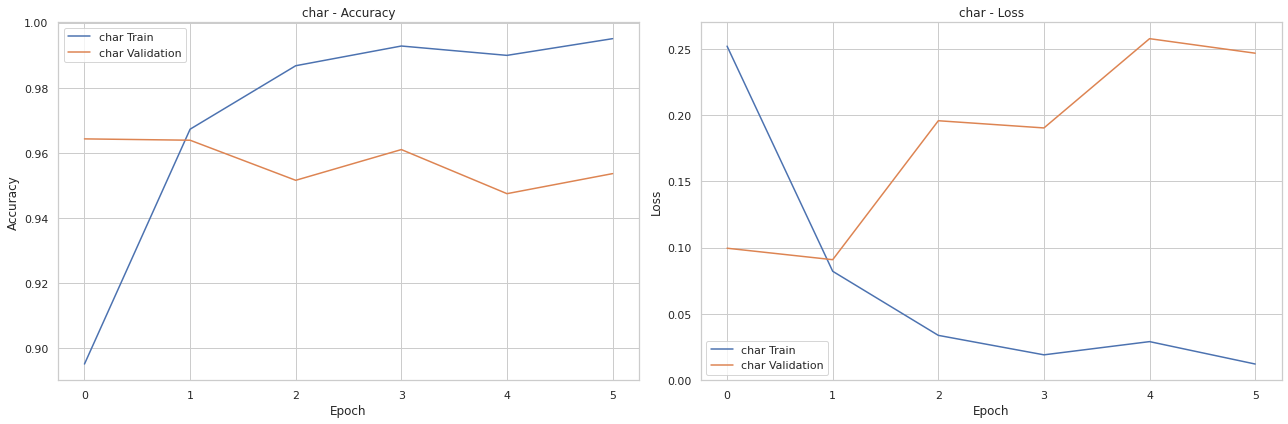

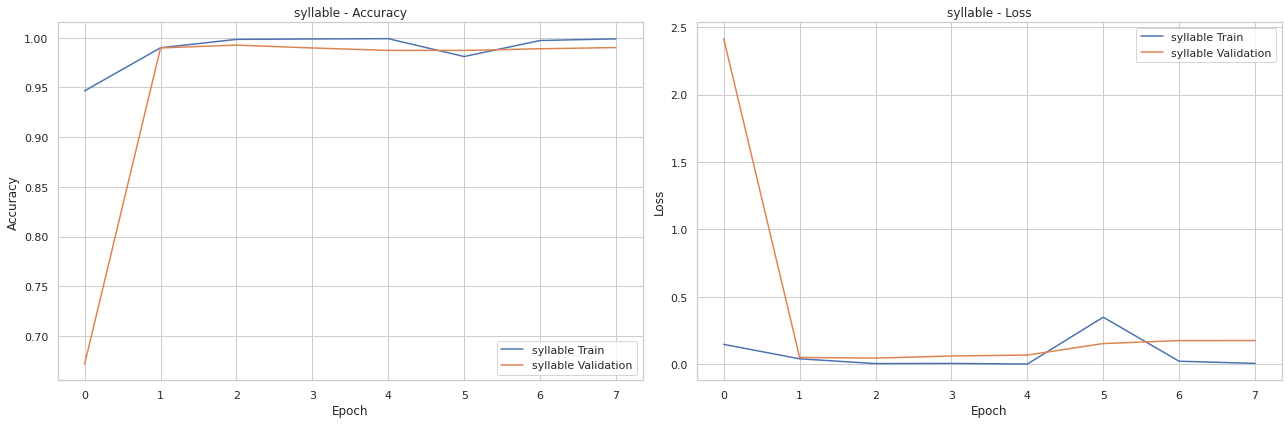

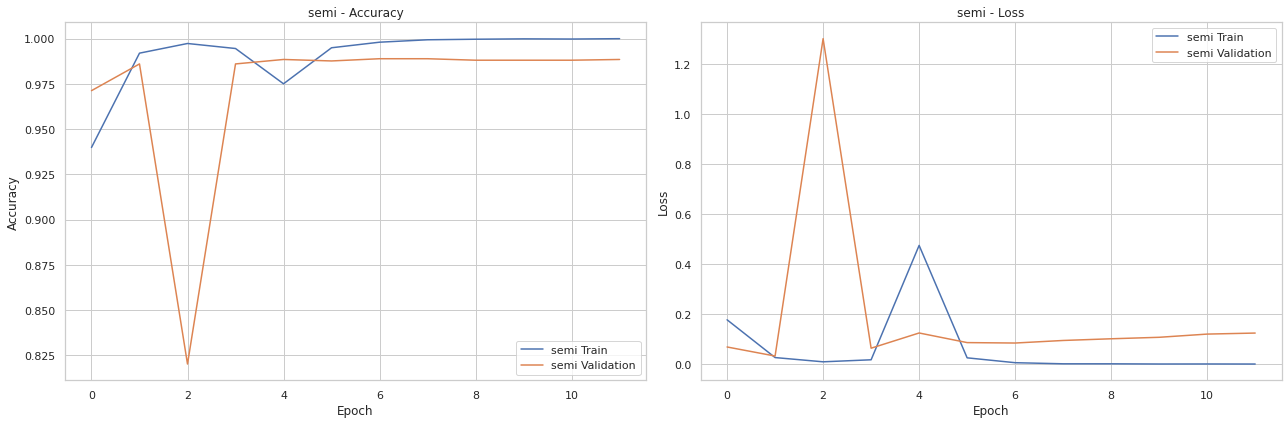

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# 1. Plot Training & Validation Metrics
for method_name in histories.keys():
    history = histories[method_name]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label=f'{method_name} Train')
    ax1.plot(history.history['val_accuracy'], label=f'{method_name} Validation')
    ax1.set_title(f'{method_name} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label=f'{method_name} Train')
    ax2.plot(history.history['val_loss'], label=f'{method_name} Validation')
    ax2.set_title(f'{method_name} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    plt.tight_layout()
    plt.show()



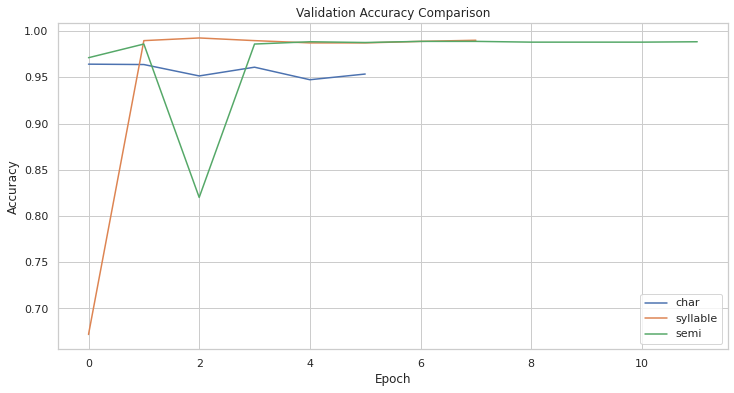

In [40]:

# 2. Comparative Accuracy Plot
plt.figure(figsize=(12, 6))
for method_name in histories.keys():
    history = histories[method_name]
    plt.plot(history.history['val_accuracy'], label=f'{method_name}')

plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

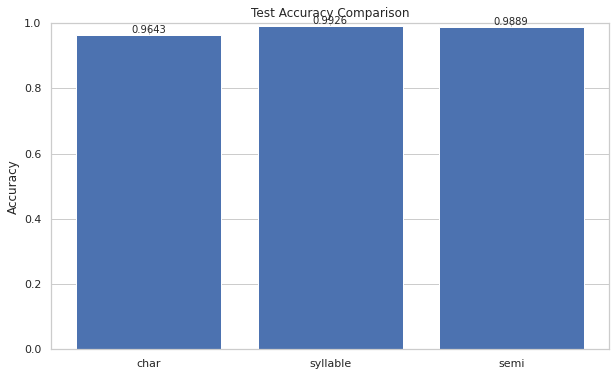

In [41]:

# 3. Test Accuracy Bar Plot
methods = list(test_results.keys())
test_accs = [result[1] for result in test_results.values()]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, test_accs)
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Since accuracy is between 0-1

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.show()

In [42]:
for MethodName in report.keys():
    print(report[MethodName])

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1992
           1       0.89      0.92      0.90       443

    accuracy                           0.96      2435
   macro avg       0.94      0.95      0.94      2435
weighted avg       0.96      0.96      0.96      2435

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1992
           1       0.97      0.99      0.98       443

    accuracy                           0.99      2435
   macro avg       0.98      0.99      0.99      2435
weighted avg       0.99      0.99      0.99      2435

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1992
           1       0.97      0.97      0.97       443

    accuracy                           0.99      2435
   macro avg       0.98      0.98      0.98      2435
weighted avg       0.99      0.99      0.99      2435



Vectorization with Myanmar-specific settings

In [43]:
for MethodName,df in datasets.items():
    joblib.dump(tokenizer, f"Tokenizer/{MethodName}_tokenizer.pkl")
    print(f"Saved tokenizer for {MethodName} as {MethodName}_tokenizer.pkl")


Saved tokenizer for char as char_tokenizer.pkl
Saved tokenizer for syllable as syllable_tokenizer.pkl
Saved tokenizer for semi as semi_tokenizer.pkl


In [44]:
for MethodName,df in models.items():
    model.save(f"Models/{MethodName}_model.keras")

